In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

fontsize = 15

In [102]:
def plot_fig(results, iwerm_gap, erm_gap, output_path=None):
    plt.plot(results['sigma'], results['trn wg acc'] - results['tst wg acc'], label="DP")
    plt.plot(results['sigma'], iwerm_gap * np.ones(len(results['sigma'])), label="IWERM")
    plt.plot(results['sigma'], erm_gap * np.ones(len(results['sigma'])), label="ERM")

    plt.xscale("log")
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlabel("sigma", fontsize=fontsize)
    plt.ylabel("worst-group accuracy gap", fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    if output_path is not None:
        plt.savefig(output_path)
    
def get_losses(model, loader):
    losses = []
    for X, y in loader:
        y_pred = model(X.cuda())
        loss = torch.nn.functional.nll_loss(
            y_pred, y.cuda(), reduction="none").detach().cpu().numpy()
        losses.append(loss)        
    return np.concatenate(losses)

def mia_opt_loss_threshold(train_losses, test_losses):
    # MIA metric is balanced accuracy.
    def _compute_mia_metric(threshold, train_losses, test_losses):
        return 0.5 * (np.mean(train_losses <= threshold) + np.mean(test_losses > threshold))
    
    best_mia_acc = 0.
    for thresh in np.concatenate([train_losses, test_losses]):
        mia_acc = _compute_mia_metric(thresh, train_losses, test_losses)
        if mia_acc > best_mia_acc:
            best_mia_acc = mia_acc
    
    return best_mia_acc, thresh

train_losses = get_losses(model, train_loader)
test_losses = get_losses(model, test_loader)
mia_acc, _ = mia_opt_loss_threshold(train_losses, test_losses) # Attack accuracy from 50% to 100%
mia_adv = 2 * mia_acc - 1  # Attack advantage from 0 to 1

NameError: name 'model' is not defined

In [99]:
ds_name = "celebA"

sigmas = [0.0001, 0.001, 0.01, 0.1]
log_paths = []
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.0001")

cols = ["acc_avg", "acc_wg", "acc_y:notblond_male:0", "acc_y:notblond_male:1", "acc_y:blond_male:0", "acc_y:blond_male:1"]
col_names = ["acc", "acc_wg", "notblond_male:0", "notblond_male:1", "blond_male:0", "blond_male:1"]

results = {}
for sigma, log_path in zip(sigmas, log_paths):
    results.setdefault("sigma", []).append(sigma)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    train_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("trn acc", []).append(train_res[-1][1])
    results.setdefault("trn wg acc", []).append(train_res[-1][1])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/val_eval.csv")
    val_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("val acc", []).append(res[-1][1])
    results.setdefault("val wg acc", []).append(res[-1][1])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"]].values.tolist()
    results.setdefault("tst acc", []).append(res[-1][1])
    results.setdefault("tst wg acc", []).append(res[-1][1])
    
for k, v in results.items():
    results[k] = np.array(v)

iwerm_paths = ["groupDRO"]
wds = [0., 0.1, 1.0]
for wd in wds[1:]:
    iwerm_paths.append(f"groupDRO_wd{wd}")

iwerm_results = {}
for wd, log_path in zip(wds, iwerm_paths):
    iwerm_results.setdefault("wds", []).append(wd)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"]].values
    iwerm_results.setdefault("trn acc", []).append(res[-1][1])
    iwerm_results.setdefault("trn wg acc", []).append(res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"]].values.tolist()
    iwerm_results.setdefault("tst acc", []).append(res[-1][1])
    iwerm_results.setdefault("tst wg acc", []).append(res[-1][2])
        
for k, v in iwerm_results.items():
    iwerm_results[k] = np.array(v)

log_path = "erm"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
erm_gap = (trn_acc_wg - tst_acc_wg)

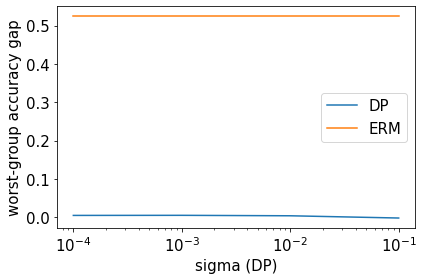

In [100]:
plt.plot(results['sigma'], results['trn wg acc'] - results['tst wg acc'], label="DP")
#plt.plot(iwerm_results['wds'], iwerm_results['trn wg acc'] - iwerm_results['tst wg acc'], label="IWERM")
#plt.plot(results['sigma'], iwerm_gap * np.ones(len(results['sigma'])), label="IWERM")
plt.plot(results['sigma'], erm_gap * np.ones(len(results['sigma'])), label="ERM")

plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma (DP)", fontsize=fontsize)
plt.ylabel("worst-group accuracy gap", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_{ds_name}.png")

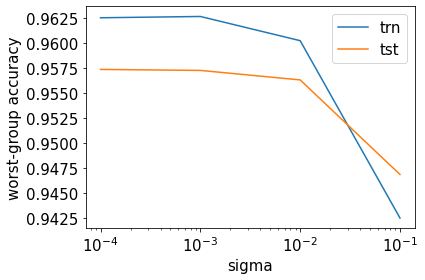

In [91]:
plt.plot(results['sigma'], results['trn wg acc'], label="trn")
plt.plot(results['sigma'], results['tst wg acc'], label="tst")
plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma", fontsize=fontsize)
plt.ylabel("worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_acc_{ds_name}.png")

In [92]:
ds_name = "utkface"

sigmas = [10.0, 1.0, 0.1, 0.01, 0.001, 0.0001]
log_paths = [
    
]
for sigma in sigmas:
    log_paths.append(f"erm-dp_resnet50-lr1e-3-dpsgd_1e-5_{sigma}_1.0_0.001")

#cols = ["acc_avg", "acc_wg", "acc_y:notblond_male:0", "acc_y:notblond_male:1", "acc_y:blond_male:0", "acc_y:blond_male:1"]
#col_names = ["acc", "acc_wg", "notblond_male:0", "notblond_male:1", "blond_male:0", "blond_male:1"]
subgroup_names = [
    'acc_y:male_race:White',
    'acc_y:male_race:Black',
    'acc_y:male_race:Asian',
    'acc_y:male_race:Indian',
    'acc_y:male_race:Others',
    'acc_y:female_race:White',
    'acc_y:female_race:Black',
    'acc_y:female_race:Asian',
    'acc_y:female_race:Indian',
    'acc_y:female_race:Others',
]
    
results = {}
for sigma, log_path in zip(sigmas, log_paths):
    results.setdefault("sigma", []).append(sigma)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    train_res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values
    results.setdefault("trn acc", []).append(train_res[-1][1])
    results.setdefault("trn wg acc", []).append(train_res[-1][2])
    for i, name in enumerate(subgroup_names):
        results.setdefault(f"trn {name}", []).append(train_res[-1][i+3])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/val_eval.csv")
    val_res = df[["epoch", "acc_avg", "acc_wg"]].values
    results.setdefault("val acc", []).append(res[-1][1])
    results.setdefault("val wg acc", []).append(res[-1][2])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values.tolist()
    results.setdefault("tst acc", []).append(res[-1][1])
    results.setdefault("tst wg acc", []).append(res[-1][2])
    for i, name in enumerate(subgroup_names):
        results.setdefault(f"tst {name}", []).append(res[-1][i+3])
    
for k, v in results.items():
    results[k] = np.array(v)
    
iwerm_paths = ["iwerm-resnet50"]
wds = [0., 0.001, 0.01, 0.1]
for wd in wds[1:]:
    iwerm_paths.append(f"iwerm-resnet50_wd{wd}")

iwerm_results = {}
for wd, log_path in zip(wds, iwerm_paths):
    iwerm_results.setdefault("wds", []).append(wd)

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values
    iwerm_results.setdefault("trn acc", []).append(res[-1][1])
    iwerm_results.setdefault("trn wg acc", []).append(res[-1][2])
    for i, name in enumerate(subgroup_names):
        iwerm_results.setdefault(f"trn {name}", []).append(res[-1][i+3])

    df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
    res = df[["epoch", "acc_avg", "acc_wg"] + subgroup_names].values.tolist()
    iwerm_results.setdefault("tst acc", []).append(res[-1][1])
    iwerm_results.setdefault("tst wg acc", []).append(res[-1][2])
    for i, name in enumerate(subgroup_names):
        iwerm_results.setdefault(f"tst {name}", []).append(res[-1][i+3])
        
for k, v in iwerm_results.items():
    iwerm_results[k] = np.array(v)
        
log_path = "iwerm-resnet50"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
iwerm_gap = (trn_acc_wg - tst_acc_wg)

log_path = "erm-resnet50"
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/train_eval.csv")
trn_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
df = pd.read_csv(f"../logs/{ds_name}/{log_path}/test_eval.csv")
tst_acc_wg = df[["epoch", "acc_avg", "acc_wg"]].values[-1][2]
erm_gap = (trn_acc_wg - tst_acc_wg)


In [93]:
df.columns

Index(['epoch', 'acc_avg', 'acc_y:male_race:White', 'count_y:male_race:White',
       'acc_y:male_race:Black', 'count_y:male_race:Black',
       'acc_y:male_race:Asian', 'count_y:male_race:Asian',
       'acc_y:male_race:Indian', 'count_y:male_race:Indian',
       'acc_y:male_race:Others', 'count_y:male_race:Others',
       'acc_y:female_race:White', 'count_y:female_race:White',
       'acc_y:female_race:Black', 'count_y:female_race:Black',
       'acc_y:female_race:Asian', 'count_y:female_race:Asian',
       'acc_y:female_race:Indian', 'count_y:female_race:Indian',
       'acc_y:female_race:Others', 'count_y:female_race:Others', 'acc_wg'],
      dtype='object')

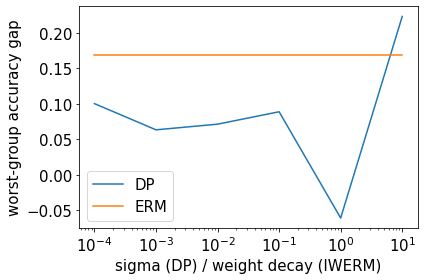

In [96]:
plt.plot(results['sigma'], results['trn wg acc'] - results['tst wg acc'], label="DP")
#plt.plot(iwerm_results['wds'], iwerm_results['trn wg acc'] - iwerm_results['tst wg acc'], label="IWERM")
#plt.plot(results['sigma'], iwerm_gap * np.ones(len(results['sigma'])), label="IWERM")
plt.plot(results['sigma'], erm_gap * np.ones(len(results['sigma'])), label="ERM")

plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma (DP) / weight decay (IWERM)", fontsize=fontsize)
plt.ylabel("worst-group accuracy gap", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_{ds_name}.png")

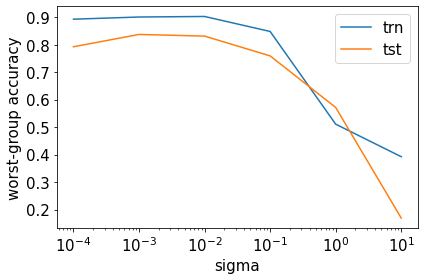

In [97]:
plt.plot(results['sigma'], results['trn wg acc'], label="trn")
plt.plot(results['sigma'], results['tst wg acc'], label="tst")
plt.xscale("log")
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel("sigma", fontsize=fontsize)
plt.ylabel("worst-group accuracy", fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
plt.savefig(f"figs/dpdg_acc_{ds_name}.png")

In [ ]:
results[]

{'sigma': array([1.e+01, 1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04]),
 'trn acc': array([0.53374159, 0.70998704, 0.90531152, 0.95789659, 0.95989871,
        0.95777881]),
 'trn wg acc': array([0.39266706, 0.51106894, 0.84824902, 0.90272373, 0.90077823,
        0.89285713]),
 'val acc': array([0.89868307, 0.527825  , 0.71665251, 0.88763809, 0.90271878,
        0.89868307]),
 'val wg acc': array([0.83734941, 0.16956921, 0.57187498, 0.75937498, 0.83132529,
        0.83734941]),
 'tst acc': array([0.527825  , 0.71665251, 0.88763809, 0.90271878, 0.89868307,
        0.89146131]),
 'tst wg acc': array([0.16956921, 0.57187498, 0.75937498, 0.83132529, 0.83734941,
        0.79250002])}